In [44]:
import findspark
import pyspark
import numpy as np
import pyspark.sql.functions as sqlFunctions
import matplotlib.pyplot as plt

from operator import add
from pyspark.sql import SQLContext

%matplotlib inline

In [18]:
findspark.init()
sc = pyspark.SparkContext()
sqlContext = SQLContext(sc)

In [19]:
# Full original training set
raw_full_train = sc.textFile("dac/train.txt")

# Final test set split
raw_final_test = sc.textFile("dac/split/test.txt")  # Do not touch during training

# Training set splits
raw_test_3m = sc.textFile("dac/split/test_3m.txt")
raw_train_5m = sc.textFile("dac/split/train_5m.txt")
raw_validation_2m = sc.textFile("dac/split/train_5m.txt")

# Debug set
raw_small_train = sc.textFile("dac/small-train.txt")

In [20]:
def convert_value(index, value):
    if index < 14:
        return int(value) if value else None
    else:
        return value if value else None

def convert_line(line):
    return [convert_value(i, value) for i, value in enumerate(line.split("\t"))]

In [21]:
# Change the data types of the datasets so that the RDD's include Int's and Strings. 
full_train = raw_full_train.map(convert_line)
final_test = raw_final_test.map(convert_line)
test_3m = raw_test_3m.map(convert_line)
train_5m = raw_train_5m.map(convert_line)
validation_2m = raw_validation_2m.map(convert_line)

debug = raw_small_train.map(convert_line)

In [22]:
# Label data histogram
debug.map(lambda row: row[0]).histogram([0,1,2])

([0, 1, 2], [77337, 22663])

In [116]:
def int_column_histogram(col_num, col):
    bins, counts = col.histogram(10)
    total = sum(counts)    
    print "Column %d histogram\n\tBins=%s\n\tCounts=%s (total=%d)" % (col_num, bins, counts, total)
    # TODO: display graph of histogram
    # TODO: better buckets for histogram (smart sub-dividing)
        #sum the counts
        #max of the counts
        #if  > 25%
    return bins,counts,total

def bin_range_labels(bins):
    return ["%s-%s" % (bins[i], bins[i + 1]) for i in range(len(bins) - 1)]

In [24]:
def get_column_num(data, col_num):
    return data.map(lambda row: row[col_num])

def column_filter_null(column):
    return column.filter(lambda row: row is not None)

def column_count(data):
    return len(data.take(1)[0])

def is_integer_col_num(col_num):
    return col_num > 1 and col_num < 15

def is_label_col_num(col_num):
    return col_num == 1

def is_categorical_col_num(col_num):
    return col_num > 15

def column_iter(data):
    for i in range(column_count(data)):
         yield get_column_num(data, i)

In [112]:
def int_columns_histograms(data):
    x=[]; y=[]; z = [];
    for i, col in enumerate(column_iter(debug)):
        col_num = i + 1
        if is_integer_col_num(col_num):
            x1,y1,z1 = int_column_histogram(col_num, col)
            x.append(x1)
            y.append(y1)
            z.append(z1)
            
    return x,y,z
def cat_columns_histogram(data):
    for i, col in enumerate(column_iter(debug)):
        col_num = i + 1
        if is_categorical_col_num(col_num):
            key_counts = col.map(lambda key: (key, 1)).reduceByKey(add)
            sorted_counts = sorted(key_counts.collect(), key=lambda t: t[1], reverse=True)
            labels = [v[0] for v in sorted_counts]
            counts = [v[1] for v in sorted_counts]
            # TODO: graph these counts
            x = labels[:10]
            y = counts[:10]
            z = sum(counts[10:])
            # TODO: truncate at something larger than 5
            print labels[:10], counts[:10], "Remaining", sum(counts[10:]), "Total", sum(counts)
            
            return x,y,z

Column 2 histogram
	Bins=[0.0, 55.6, 111.2, 166.8, 222.4, 278.0, 333.6, 389.2, 444.8, 500.40000000000003, 556]
	Counts=[55236, 295, 34, 10, 5, 3, 2, 0, 1, 1] (total=55587)
Column 3 histogram
	Bins=[-2.0, 1850.4, 3702.8, 5555.200000000001, 7407.6, 9260.0, 11112.400000000001, 12964.800000000001, 14817.2, 16669.600000000002, 18522]
	Counts=[98530, 1397, 52, 12, 7, 0, 1, 0, 0, 1] (total=100000)
Column 4 histogram
	Bins=[0.0, 6553.5, 13107.0, 19660.5, 26214.0, 32767.5, 39321.0, 45874.5, 52428.0, 58981.5, 65535]
	Counts=[80863, 11, 1, 20, 0, 0, 0, 0, 1, 2] (total=80898)
Column 5 histogram
	Bins=[0.0, 41.7, 83.4, 125.10000000000001, 166.8, 208.5, 250.20000000000002, 291.90000000000003, 333.6, 375.3, 417]
	Counts=[79210, 1178, 44, 8, 12, 6, 5, 0, 0, 3] (total=80466)
Column 6 histogram
	Bins=[0.0, 174112.8, 348225.6, 522338.39999999997, 696451.2, 870564.0, 1044676.7999999999, 1218789.5999999999, 1392902.4, 1567015.2, 1741128]
	Counts=[93216, 1145, 491, 218, 88, 44, 19, 11, 5, 3] (total=95240)
C

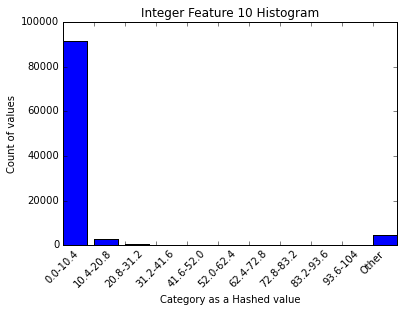

In [140]:
x=[];y=[];z=[]
x,y,z = int_columns_histograms(debug)

# Append "Other values not in top 10 count"
for i in range(len(z)):
    y[i].append(100000-z[i])

column_numb = 10 #This number must be set. 
plt.title('Integer Feature %s Histogram' % (column_numb))
plt.ylabel('Count of values')
plt.xlabel('Bins of Integer values')
x1 = np.array([0,1,2,3,4,5,6,7,8,9,10])
x2 = []


x2 = bin_range_labels(x[column_numb])
x2.append('Other')

plt.xticks(x1, x2,rotation=45)
plt.bar(x1, y[column_numb])
plt.show()


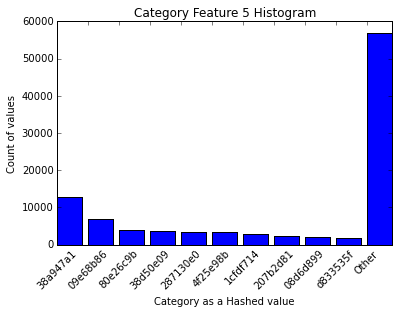

56826


In [101]:
#int_columns_histograms(debug)
x,y,z = cat_columns_histogram(debug)


# This represents the Histograms for Category Features. 

column_numb = 5 #This number must be set. 
plt.title('Category Feature %s Histogram' % (column_numb))
plt.ylabel('Count of values')
plt.xlabel('Category as a Hashed value')
x1 = np.array([0,1,2,3,4,5,6,7,8,9,10])
x2 = []
for i in x: 
    x2.append(str(i))
    
x2.append('Other')
y.append(z)
plt.xticks(x1, x2,rotation=45)
plt.bar(x1, y)
plt.show()


['38a947a1', '09e68b86', '80e26c9b', '38d50e09', '287130e0', '4f25e98b', '1cfdf714', '207b2d81', '08d6d899', 'd833535f']


In [27]:
cat_columns_histogram(debug)

[u'38a947a1', u'09e68b86', u'80e26c9b', u'38d50e09', u'287130e0', u'4f25e98b', u'1cfdf714', u'207b2d81', u'08d6d899', u'd833535f'] [12895, 6826, 4043, 3724, 3269, 3268, 2903, 2366, 1988, 1892] Remaining 56826 Total 100000
[None, u'd032c263', u'b00d1501', u'02cf9876', u'aa8c1539', u'77f2f2e5', u'74e1a23a', u'9143c832', u'2cbec47f', u'ad4b77ff'] [3935, 3703, 1900, 1707, 1579, 1571, 1058, 972, 900, 855] Remaining 81820 Total 100000
[u'c18be181', u'd16679b9', None, u'85dd697c', u'13508380', u'f922efad', u'9a6888fb', u'f56b7dd5', u'3e2bfbda', u'29998ed1'] [5410, 4380, 3935, 3235, 2330, 1487, 1058, 972, 908, 895] Remaining 75390 Total 100000
[u'25c83c98', u'4cf72387', u'43b19349', u'384874ce', u'30903e74', u'0942e0a7', u'f281d2a7', u'b0530c50', u'b2241560', u'f3474129'] [67056, 15783, 6228, 3224, 1990, 1313, 874, 560, 483, 374] Remaining 2115 Total 100000
[u'7e0ccccf', u'fbad5c96', None, u'fe6b92e5', u'13718bbd', u'6f6d9be8', u'3bf701e7', u'e3520422', u'f1f2de2d', u'c05778d5'] [46438, 19331,

In [28]:
def print_column_summary(col_num, mean, stdev, var):
    print("Column #%2d: Mean=%-10.3f Stdev=%-10.3f Variance=%-10.3f" % (
          col_num, mean, stdev, var))
        

def int_columns_basic_summary_stats(data):
    for i, col in enumerate(column_iter(data)):
        col_num = i + 1
        if is_integer_col_num(col_num):
            mean = column_filter_null(col).mean()
            stdev = column_filter_null(col).sampleStdev()
            var = column_filter_null(col).sampleVariance()
            print_column_summary(col_num, mean, stdev, var)

In [29]:
int_columns_basic_summary_stats(debug)

Column # 2: Mean=3.769      Stdev=10.451     Variance=109.228   
Column # 3: Mean=112.864    Stdev=401.523    Variance=161220.427
Column # 4: Mean=40.745     Stdev=538.819    Variance=290325.723
Column # 5: Mean=8.280      Stdev=10.836     Variance=117.426   
Column # 6: Mean=17592.599  Stdev=65797.898  Variance=4329363390.243
Column # 7: Mean=139.685    Stdev=371.776    Variance=138217.462
Column # 8: Mean=15.222     Stdev=65.460     Variance=4285.075  
Column # 9: Mean=13.575     Stdev=46.542     Variance=2166.120  
Column #10: Mean=125.295    Stdev=286.416    Variance=82033.945 
Column #11: Mean=0.620      Stdev=0.677      Variance=0.458     
Column #12: Mean=2.400      Stdev=4.630      Variance=21.436    
Column #13: Mean=0.938      Stdev=5.328      Variance=28.384    
Column #14: Mean=11.608     Stdev=52.045     Variance=2708.636  


In [30]:
def print_column_summary_details(col_num, kurtosis, skewness):
    print("Column #%2d: Kurtosis=%-10.3f Skewness=%-10.3f" % (col_num, kurtosis, skewness))

def int_columns_detail_stats(data):
    df = sqlContext.createDataFrame(data)
    for i, col in enumerate(column_iter(data)):
        col_num = i + 1
        if is_integer_col_num(col_num):            
            col = df["_%s" % col_num]
            k_col = sqlFunctions.kurtosis(col)
            k_result = df.select(k_col.alias("kurtosis")).collect()[0]
            s_col = sqlFunctions.skewness(col)
            s_result = df.select(s_col.alias("skewness")).collect()[0]
            print_column_summary_details(col_num, k_result.kurtosis, s_result.skewness)

In [31]:
int_columns_detail_stats(debug)

Column # 2: Kurtosis=373.759    Skewness=13.045    
Column # 3: Kurtosis=100.708    Skewness=7.264     
Column # 4: Kurtosis=7426.228   Skewness=74.676    
Column # 5: Kurtosis=115.569    Skewness=5.891     
Column # 6: Kurtosis=115.043    Skewness=9.146     
Column # 7: Kurtosis=251.298    Skewness=11.409    
Column # 8: Kurtosis=4233.619   Skewness=42.413    
Column # 9: Kurtosis=5577.523   Skewness=68.854    
Column #10: Kurtosis=163.166    Skewness=9.010     
Column #11: Kurtosis=2.495      Skewness=1.125     
Column #12: Kurtosis=66.442     Skewness=6.399     
Column #13: Kurtosis=3362.307   Skewness=42.705    
Column #14: Kurtosis=5899.185   Skewness=67.003    


In [32]:
a = int_columns_histograms(debug)

Column 2 histogram
	Bins=[0.0, 55.6, 111.2, 166.8, 222.4, 278.0, 333.6, 389.2, 444.8, 500.40000000000003, 556]
	Counts=[55236, 295, 34, 10, 5, 3, 2, 0, 1, 1] (total=55587)
Column 3 histogram
	Bins=[-2.0, 1850.4, 3702.8, 5555.200000000001, 7407.6, 9260.0, 11112.400000000001, 12964.800000000001, 14817.2, 16669.600000000002, 18522]
	Counts=[98530, 1397, 52, 12, 7, 0, 1, 0, 0, 1] (total=100000)
Column 4 histogram
	Bins=[0.0, 6553.5, 13107.0, 19660.5, 26214.0, 32767.5, 39321.0, 45874.5, 52428.0, 58981.5, 65535]
	Counts=[80863, 11, 1, 20, 0, 0, 0, 0, 1, 2] (total=80898)
Column 5 histogram
	Bins=[0.0, 41.7, 83.4, 125.10000000000001, 166.8, 208.5, 250.20000000000002, 291.90000000000003, 333.6, 375.3, 417]
	Counts=[79210, 1178, 44, 8, 12, 6, 5, 0, 0, 3] (total=80466)
Column 6 histogram
	Bins=[0.0, 174112.8, 348225.6, 522338.39999999997, 696451.2, 870564.0, 1044676.7999999999, 1218789.5999999999, 1392902.4, 1567015.2, 1741128]
	Counts=[93216, 1145, 491, 218, 88, 44, 19, 11, 5, 3] (total=95240)
C